# DISTANCES AND REDSHIFTS
In this scenario we have some (simulated) data of redshift and distance modulus measured through supernovae of type Ia. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
from astroML.linear_model import PolynomialRegression, NadarayaWatson
from sklearn.preprocessing import StandardScaler

/home/diego/.local/lib/python3.12/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


Text(0, 0.5, '$\\mu$')

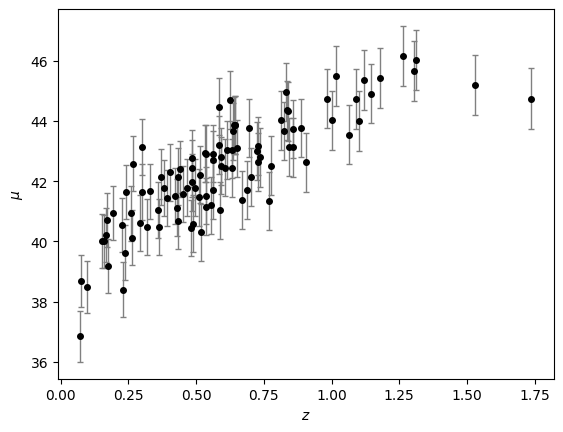

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
plt.errorbar(z_sample, mu_sample, dmu, fmt='o', color='black', ecolor='gray', markersize=4, lw=1, capsize=2)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")

## Polynomial fit
We want to fit them with a polynomial. The first thing we do is a fit with various polynomials, to see which seems to fit best the data:

In [3]:
degmax = 15
xgrid = np.linspace(0, 1.80, 1000)
ygrid = np.zeros((degmax, 1000))

for deg in range(1, degmax + 1):
    reg = PolynomialRegression(deg)
    reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    ygrid[deg - 1] = reg.predict(xgrid[:, np.newaxis])

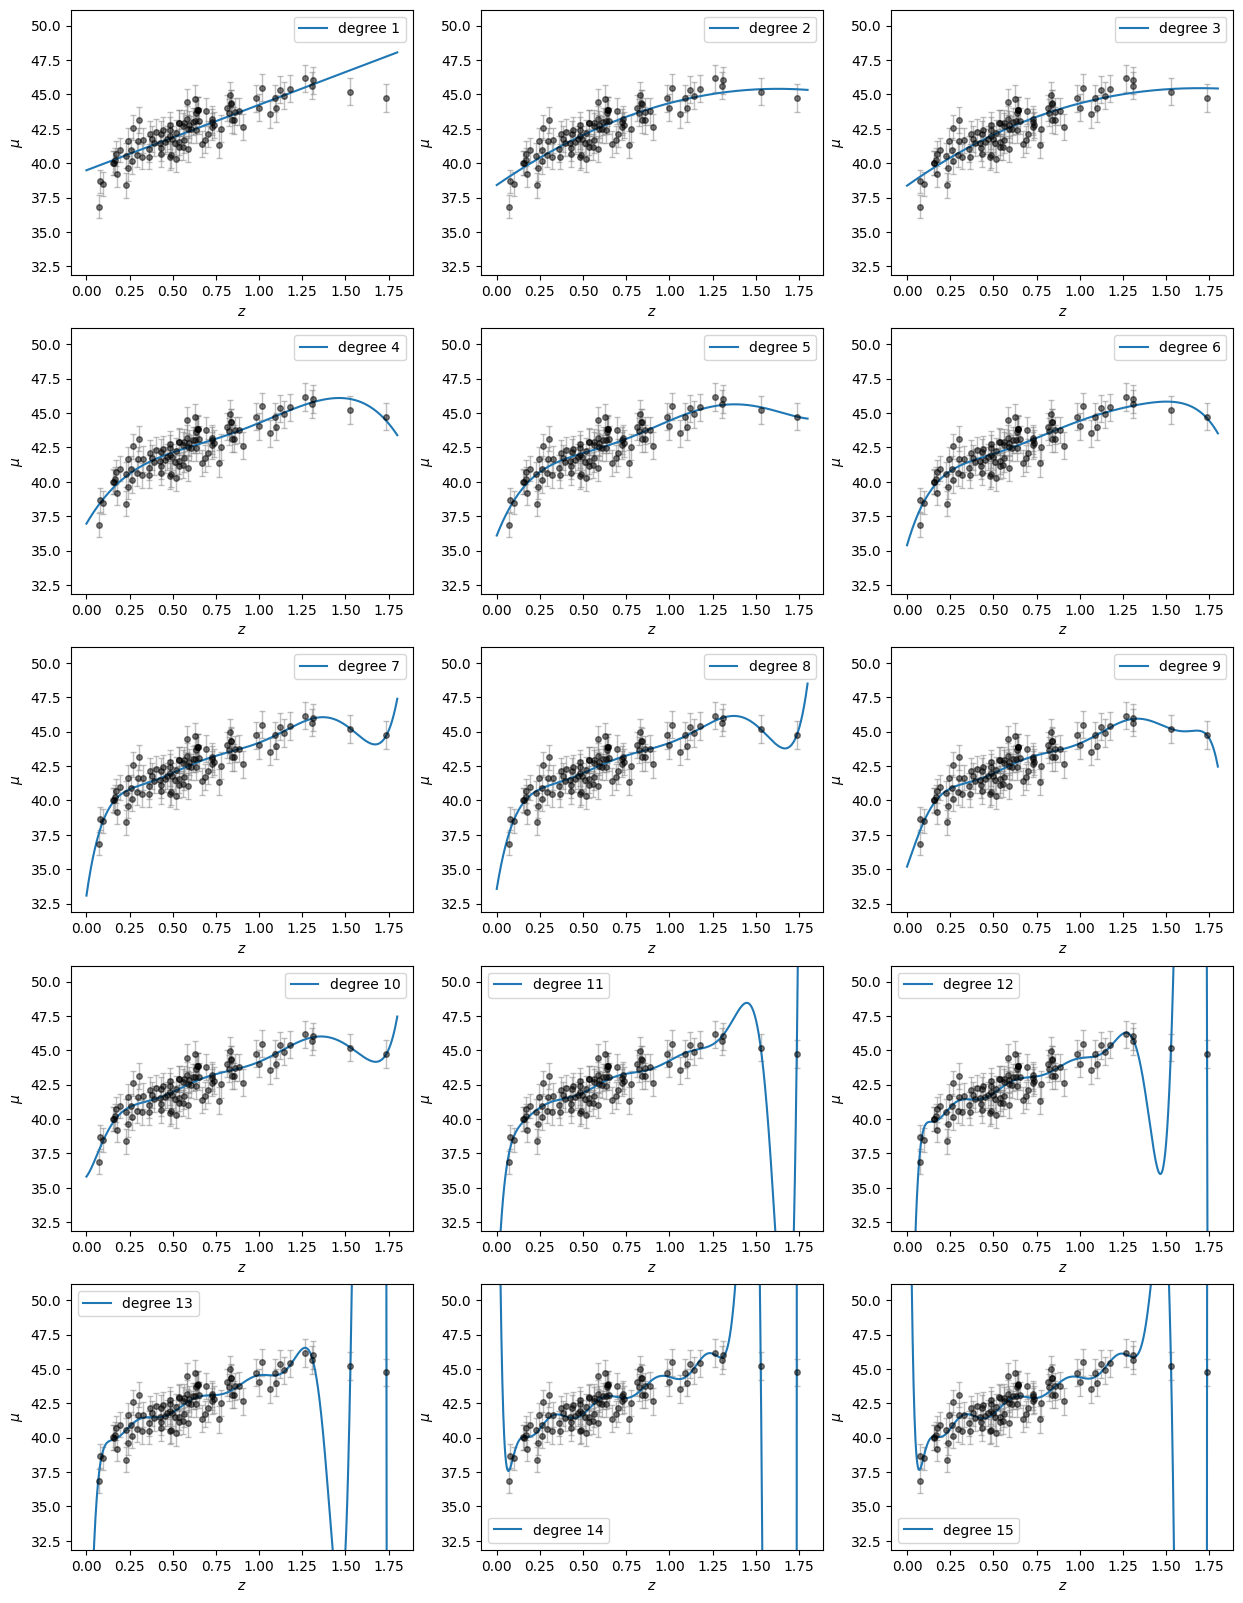

In [4]:
plt.figure(figsize=(15, 20))

for deg in range(1, degmax + 1):
    plt.subplot(5, 3, deg)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='o', color='black', ecolor='gray', markersize=4, lw=1, capsize=2, alpha = 0.5)
    plt.plot(xgrid, ygrid[deg - 1], label = "degree {}".format(deg))
    plt.legend()
    plt.xlabel(r"$z$")
    plt.ylabel(r"$\mu$")
    plt.ylim(np.min(mu_sample)-5.0, np.max(mu_sample) + 5.0)

We see here that the first two polynomials seems to underfit the data, whereas from, say, the seventh degree polynomial it seems to overfit the data. But it's difficult to pick up the right function from the third to the sixth degree polynomial. So we do cross-validation. We'll proceed with a 10-fold validation:

Text(0, 0.5, 'RMS')

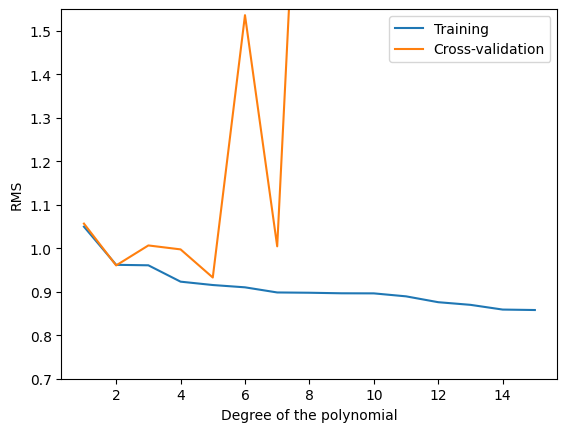

In [5]:
rng = np.random.default_rng(seed=130301)
indices = np.arange(len(z_sample))
rng.shuffle(indices)

K = 10
degmax = 15

train_len = int(len(z_sample) - len(z_sample) / K)
val_len = int(len(z_sample) / K)
rms_tr = np.zeros(K)
rms_te = np.zeros(K)
rms_tr_model = np.zeros(degmax)
rms_te_model = np.zeros(degmax)
for deg in range(1, degmax + 1):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(z_sample)])
        reg = PolynomialRegression(deg)
        reg.fit(z_sample[train_data][:, np.newaxis], mu_sample[train_data], dmu[train_data])
        pred_train = reg.predict(z_sample[train_data][:, np.newaxis])
        pred_test = reg.predict(z_sample[test_data][:, np.newaxis])
        rms_tr[i] = np.sqrt(np.sum(((mu_sample[train_data] - pred_train) ** 2) / dmu[train_data] ** 2)/len(train_data))
        rms_te[i] = np.sqrt(np.sum(((mu_sample[test_data] - pred_test) ** 2) / dmu[test_data] ** 2)/len(test_data))
    rms_tr_model[deg-1], rms_te_model[deg-1] = np.mean(rms_tr), np.mean(rms_te)

plt.plot(range(1, degmax + 1), rms_tr_model, label="Training")
plt.plot(range(1, degmax + 1), rms_te_model, label="Cross-validation")
plt.ylim(0.7, np.max(rms_tr_model) + 0.5)
plt.legend()
plt.xlabel("Degree of the polynomial")
plt.ylabel("RMS")

The fifth degree polynomial seems to be the best, but it depends a bit, even though there is the k-fold cross-validation, on how the dataset is split into the k-folds.

We can see if the data used to fit are enough looking at the learning curve:

Text(0.5, 1.0, 'Learning curve')

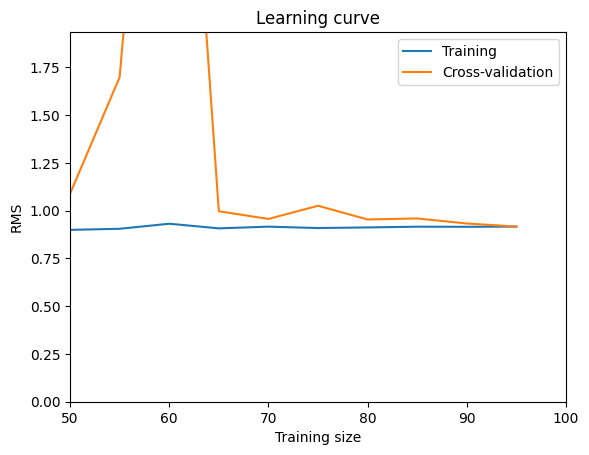

In [6]:
degbest = 5
delta = 5

rms_tr_model = np.array([])
rms_te_model = np.array([])
for train_len in range(10, len(z_sample), delta):
    val_len = int(len(z_sample) - train_len)
    K = int(len(z_sample) / val_len)
    rms_tr = np.zeros(K)
    rms_te = np.zeros(K)
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(z_sample)])
        reg = PolynomialRegression(degbest)
        reg.fit(z_sample[train_data][:, np.newaxis], mu_sample[train_data], dmu[train_data])
        pred_train = reg.predict(z_sample[train_data][:, np.newaxis])
        pred_test = reg.predict(z_sample[test_data][:, np.newaxis])
        rms_tr[i] = np.sqrt(np.sum(((mu_sample[train_data] - pred_train) ** 2) / dmu[train_data] ** 2)/len(train_data))
        rms_te[i] = np.sqrt(np.sum(((mu_sample[test_data] - pred_test) ** 2) / dmu[test_data] ** 2)/len(test_data))
    rms_tr_model = np.append(rms_tr_model, np.mean(rms_tr))
    rms_te_model = np.append(rms_te_model, np.mean(rms_te))

plt.plot(range(10, len(z_sample), delta), rms_tr_model, label="Training")
plt.plot(range(10, len(z_sample), delta), rms_te_model, label="Cross-validation")
plt.ylim(0.0, np.max(rms_tr_model) + 1)
plt.xlim(50, 100)
plt.legend()
plt.xlabel("Training size")
plt.ylabel("RMS")
plt.title("Learning curve")

Looking at the learning curve, we see that the data we have are just enough to train our model, so it was a good choice not to keep some test data.

Now that we now which is the best model, we can plot it.

Text(0.5, 1.0, 'The best model: fifth degree polinomial')

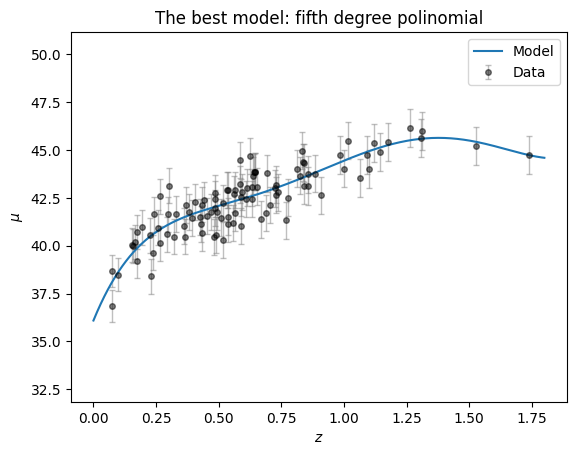

In [7]:
reg = PolynomialRegression(degbest)
reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)

plt.errorbar(z_sample, mu_sample, dmu, fmt='o', color='black', ecolor='gray', markersize=4, lw=1, capsize=2, alpha = 0.5, label = 'Data')
plt.plot(xgrid, reg.predict(xgrid[:, np.newaxis]), label = "Model")
plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.ylim(np.min(mu_sample)-5.0, np.max(mu_sample) + 5.0)
plt.title("The best model: fifth degree polinomial")

# Kernel Regression
We now want to fi the same data but using a kernel regression. In this case we need to cross-validate the bandwidth of the kernel. Again we'll do a 10-fold validation:

Text(0, 0.5, 'RMS')

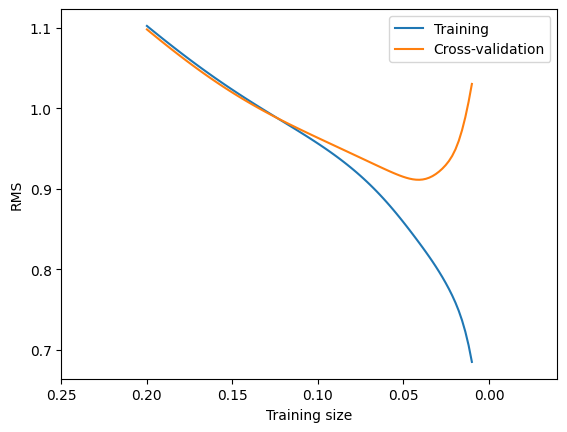

In [8]:
K = 10

train_len = int(len(z_sample) - len(z_sample) / K)
val_len = int(len(z_sample) / K)
rms_tr = np.zeros(K)
rms_te = np.zeros(K)
rms_tr_model = np.zeros(0)
rms_te_model = np.zeros(0)
h = np.linspace(0.2, 0.01, 100)
for h_act in range(h.shape[0]):
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(z_sample)])
        reg = NadarayaWatson(kernel='gaussian', h=h[h_act])
        reg.fit(z_sample[train_data][:, np.newaxis], mu_sample[train_data], dmu[train_data])
        pred_train = reg.predict(z_sample[train_data][:, np.newaxis])
        pred_test = reg.predict(z_sample[test_data][:, np.newaxis])
        rms_tr[i] = np.sqrt(np.sum(((mu_sample[train_data] - pred_train) ** 2) / dmu[train_data] ** 2)/len(train_data))
        rms_te[i] = np.sqrt(np.sum(((mu_sample[test_data] - pred_test) ** 2) / dmu[test_data] ** 2)/len(test_data))
    rms_tr_model = np.append(rms_tr_model, np.mean(rms_tr))
    rms_te_model = np.append(rms_te_model, np.mean(rms_te))

plt.plot(h, rms_tr_model, label="Training")
plt.plot(h, rms_te_model, label="Cross-validation")
plt.xlim(0.25, -0.04)
plt.legend()
plt.xlabel("Training size")
plt.ylabel("RMS")

We consider the best bandwidth to be the one with the lowest cross-validation error. Again let's see if the number of points used are enough to train the model:

Text(0.5, 1.0, 'Learning curve')

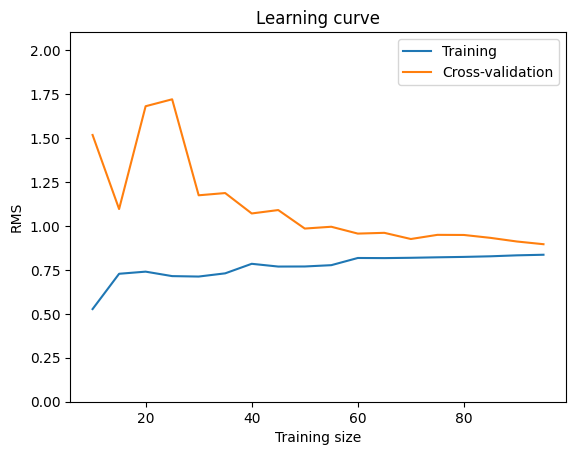

In [9]:
h_best = h[np.argmin(rms_te_model)]
delta = 5

rms_tr_model_lc = np.array([])
rms_te_model_lc = np.array([])
for train_len in range(10, len(z_sample), delta):
    val_len = int(len(z_sample) - train_len)
    K = int(len(z_sample) / val_len)
    rms_tr = np.zeros(K)
    rms_te = np.zeros(K)
    for i in range(0, K):
        test_data = indices[val_len * i : val_len * (i+1)]
        train_data = indices[0:val_len * i]
        train_data = np.append(train_data, indices[val_len * (i+1) : len(z_sample)])
        reg = NadarayaWatson(kernel='gaussian', h = h_best)
        reg.fit(z_sample[train_data][:, np.newaxis], mu_sample[train_data], dmu[train_data])
        pred_train = reg.predict(z_sample[train_data][:, np.newaxis])
        pred_test = reg.predict(z_sample[test_data][:, np.newaxis])
        rms_tr[i] = np.sqrt(np.sum(((mu_sample[train_data] - pred_train) ** 2) / dmu[train_data] ** 2)/len(train_data))
        rms_te[i] = np.sqrt(np.sum(((mu_sample[test_data] - pred_test) ** 2) / dmu[test_data] ** 2)/len(test_data))
    rms_tr_model_lc = np.append(rms_tr_model_lc, np.mean(rms_tr))
    rms_te_model_lc = np.append(rms_te_model_lc, np.mean(rms_te))

plt.plot(range(10, len(z_sample), delta), rms_tr_model_lc, label="Training")
plt.plot(range(10, len(z_sample), delta), rms_te_model_lc, label="Cross-validation")
plt.ylim(0.0, np.max(rms_tr_model) + 1)
#plt.xlim(50, 100)
plt.legend()
plt.xlabel("Training size")
plt.ylabel("RMS")
plt.title("Learning curve")

In this case, the learning curve seems to show that we should collect a bit more data to reach the best performance of the model. 

Now we can plot it:

Text(0.5, 1.0, 'Best model: bandwidth equal to 0.041')

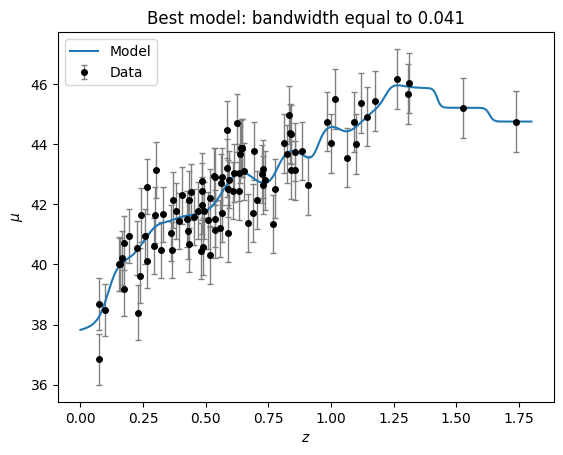

In [10]:
NW_model = NadarayaWatson(kernel='gaussian', h=h[np.argmin(rms_te_model)])
NW_model.fit(z_sample[:, np.newaxis], mu_sample)

NW_y = NW_model.predict(xgrid[:, np.newaxis])
plt.errorbar(z_sample, mu_sample, dmu, fmt='o', color='black', ecolor='gray', markersize=4, lw=1, capsize=2, label = 'Data')
plt.plot(xgrid, NW_y, label = 'Model')
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()
plt.title("Best model: bandwidth equal to {:.3f}".format(h[np.argmin(rms_te_model)]))